In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [3]:
# Reading in model-ready data
df = pd.read_csv('datasets/train_model_ready.csv')
test = pd.read_csv('datasets/test_model_ready.csv')

## Use lasso for feature selection and then test ridge, linear regression, and lasso to test for best performance

    I. Polynomial tranformation for feature interpretation
    
    II. Lasso - Feature selection
    
    III. Test for best peforming model
        1. Lasso
        2. Ridge

    IV. Summary of model performance



### I. Polynomial tranformation for feature interpretation

In [18]:
features = list(df.drop(labels='saleprice', axis = 1).columns)

test_temp = test[features]
df_temp = df[features]
test.shape , df.shape

((879, 285), (2049, 275))

In [19]:
poly = PolynomialFeatures(include_bias=False)
df_poly = poly.fit_transform(df_temp)
test_poly = poly.transform(test_temp)
df_poly.shape , test_poly.shape

((2049, 37949), (879, 37949))

In [20]:
poly_col_names = poly.get_feature_names(features)
df_poly = pd.DataFrame(df_poly, columns = poly_col_names)
test_poly = pd.DataFrame(test_poly, columns = poly_col_names)

In [21]:
df_poly['saleprice'] = df['saleprice']
test_poly['saleprice'] = test['saleprice']

   ### II. Building Lasso Regression Model for feature selection

In [57]:
X_train.shape

(1536, 274)

In [58]:
features = list(df_poly.drop(labels='saleprice', axis = 1).columns)

X = df_poly[features]
y = np.log(df_poly['saleprice'])
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [59]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lcv', LassoCV(cv = 3, max_iter=10000))
])

In [60]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lcv', LassoCV(alphas=None, copy_X=True, cv=3, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False))])

In [61]:
# Checking alpha range of the model
print('Alpha: ', pipe.named_steps['lcv'].alpha_)
print('Alpha range: ', min(pipe.named_steps['lcv'].alphas_), max(pipe.named_steps['lcv'].alphas_))

Alpha:  0.007645252691695346
Alpha range:  0.0003548611952392115 0.35486119523921156


In [62]:
# Testing the r^2 of the model
print('Test score: ', pipe.score(X_test, y_test))
print('Train score: ', pipe.score(X_train, y_train))
print('Cross_Val score: ', cross_val_score(pipe, X_train, y_train).mean())

Test score:  0.9362666314194662
Train score:  0.9468761739708879


/Users/dmitriy/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Cross_Val score:  0.8868571217090597


In [63]:
# Testing mean squared error
preds = np.exp(pipe.predict(X_test))
np.sqrt(mean_squared_error(np.exp(y_test), preds))

19736.673966047616

In [65]:
# Selecting top features 
X_final = test_poly[features]

test['SalePrice'] = np.exp(pipe.predict(X_final))
final = test[['id','SalePrice']]
final.to_csv('datasets/lasso_features.csv', index=False)
final.head()

,id,SalePrice
0,2658,142851.877950
1,2718,157171.870085
2,2414,210225.882885
3,1989,102857.410836
4,625,171336.499128


In [66]:
sum([i==0 for i in pipe.named_steps['lcv'].coef_])

37726

In [67]:
len(pipe.named_steps['lcv'].coef_)

37949

In [68]:
sum([i==0 for i in pipe.named_steps['lcv'].coef_])/len(pipe.named_steps['lcv'].coef_)

0.9941236923239084

    The model removed 99.4% of the features so we are going to only use the variables the model decided to keep

In [69]:
coefs = pd.DataFrame({
    'variable': X_train.columns,
    'coefs': pipe.named_steps['lcv'].coef_
})
#coefs.sort_values(by= 'coefs').head(10)

In [70]:
coefs.sort_values(by= 'coefs', ascending= False).head(10)

,variable,coefs
1409,overall_qual lot_area_log,0.091551
1953,year_built gr_liv_area_log,0.079870
1645,overall_cond gr_liv_area,0.037363
1641,overall_cond total_bsmt_sf,0.029754
1904,year_built year_remod/add,0.023927
3717,total_bsmt_sf functional_Typ,0.013607
12531,lot_area_log gr_liv_area_log,0.013556
2808,bsmtfin_sf_1 condition_1_Norm,0.013281
3501,total_bsmt_sf bsmt_full_bath,0.011764
4569,gr_liv_area years_since_built_sqrt_new,0.010887


In [71]:
coefs = coefs[abs(coefs['coefs'])!=0]
new_features = list(coefs['variable'])

In [72]:
len(new_features)

223

### II. 1. Running Lasso Regression Model

In [81]:
Xl = df_poly[new_features]
yl = np.log(df_poly['saleprice'])
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(Xl, yl)

In [82]:
pipe_l = Pipeline([
    ('ss', StandardScaler()),
    ('lcv', LassoCV(cv = 3, max_iter=10000))
])

In [83]:
pipe_l.fit(X_train_l, y_train_l)

Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lcv', LassoCV(alphas=None, copy_X=True, cv=3, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False))])

In [84]:
# Checking alpha range of the model
print('Alpha: ', pipe_l.named_steps['lcv'].alpha_)
print('Alpha range:', min(pipe_l.named_steps['lcv'].alphas_), max(pipe_l.named_steps['lcv'].alphas_))

Alpha:  0.001981148044683653
Alpha range: 0.0003462112472704374 0.3462112472704375


In [91]:
# Testing the r^2 of the model
print('Test score:', pipe_l.score(X_test_l, y_test_l))
print('Train score:', pipe_l.score(X_train_l, y_train_l))
print('Cross_Val score:', cross_val_score(pipe_l, X_train_l, y_train_l).mean())

Test score: 0.9174125999607348
Train score: 0.9592672926098758


/Users/dmitriy/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Cross_Val score: 0.9412810443573084


In [92]:
# Testing mean squared error
preds_l = np.exp(pipe_l.predict(X_test_l))
np.sqrt(mean_squared_error(np.exp(y_test_l), preds_l))

18097.103095194947

In [94]:
X_final_l = test_poly[new_features]

test['SalePrice'] = np.exp(pipe_l.predict(X_final_l))
final_l = test[['id','SalePrice']]
final_l['id'] = final_l['id'].astype('int')
final_l.to_csv('datasets/lasso_features.csv', index=False)
final_l.head()

/Users/dmitriy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,id,SalePrice
0,2658,107463.306422
1,2718,147456.322077
2,2414,220735.888999
3,1989,105615.807797
4,625,172733.786766


### II. 2. Running Ridge Regression Model

In [96]:
Xr = df_poly[new_features]
yr = np.log(df_poly['saleprice'])
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(Xr, yr)

In [102]:
ridge_alphas = np.logspace(0,5,1000)

In [103]:
pipe_r = Pipeline([
    ('ss', StandardScaler()),
    ('rcv', RidgeCV(ridge_alphas, cv = 3))
])

In [104]:
pipe_r.fit(X_train_r, y_train_r)

Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rcv', RidgeCV(alphas=array([1.00000e+00, 1.01159e+00, ..., 9.88542e+04, 1.00000e+05]),
    cv=3, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False))])

In [108]:
# Checking alpha range of the model
print('Alpha:', pipe_r.named_steps['rcv'].alpha_)
print('Alpha range:', min(pipe_r.named_steps['rcv'].alphas), max(pipe_r.named_steps['rcv'].alphas))

Alpha: 94.83681866285923
Alpha range: 1.0 100000.0


In [109]:
# Testing the r^2 of the model
print('Test score: ', pipe_r.score(X_test_r, y_test_r))
print('Train score: ', pipe_r.score(X_train_r, y_train_r))
print('Cross_Val score: ', cross_val_score(pipe_r, X_train_r, y_train_r).mean())

Test score:  0.9121292326499307
Train score:  0.9606040989325488


/Users/dmitriy/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Cross_Val score:  0.9408754626923783


In [110]:
# Testing mean squared error
preds_r = np.exp(pipe_r.predict(X_test_r))
np.sqrt(mean_squared_error(np.exp(y_test_r), preds_r))

18932.673186223215

In [115]:
X_final_r = test_poly[new_features]

test['SalePrice'] = np.exp(pipe_r.predict(X_final_r))
final_r = test[['id','SalePrice']]
final_r['id'] = final_r['id'].astype('int')
final_r.to_csv('datasets/ridge_features.csv', index=False)
final_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 2 columns):
id           879 non-null int64
SalePrice    879 non-null float64
dtypes: float64(1), int64(1)
memory usage: 13.8 KB


/Users/dmitriy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Visualizing Errors

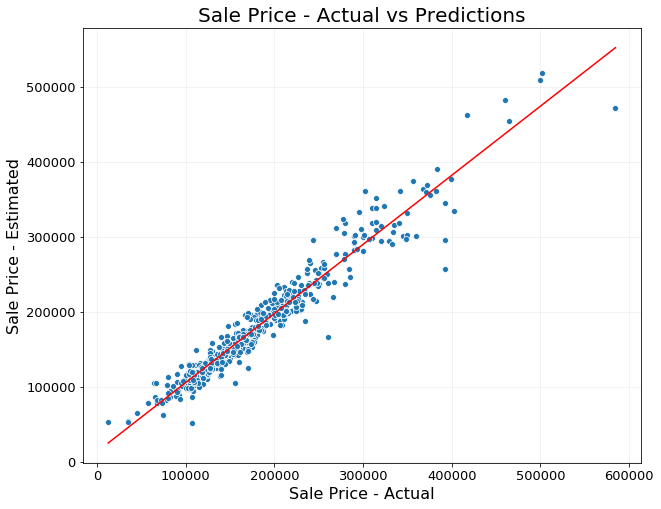

In [117]:
plt.figure(figsize = (10,8))
sns.scatterplot(x = np.exp(y_test_r), y= preds_r)
plt.title('Sale Price - Actual vs Predictions', fontsize = 20)
plt.ylabel('Sale Price - Estimated', fontsize = 16)
plt.xlabel('Sale Price - Actual', fontsize = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.grid(True, linewidth=0.5, linestyle = '-', c='black', alpha = 0.1)

plt.plot(np.unique(np.exp(y_test_r)), 
        np.poly1d(np.polyfit(np.exp(y_test_r), preds_r, 1))(np.unique(np.exp(y_test_r))), c = 'r')
plt.savefig("Images/actual_vs_forecast")

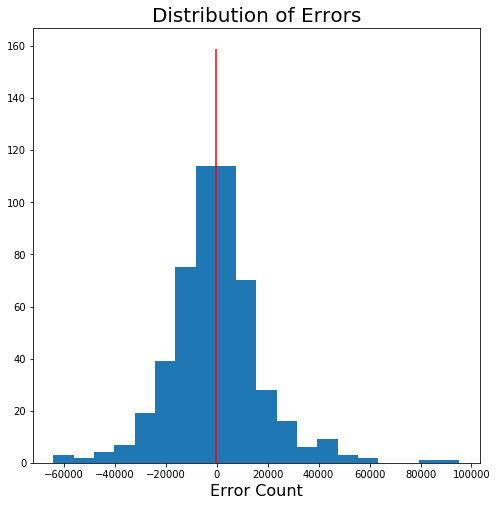

In [123]:
plt.figure(figsize=(8,8))

errors = np.exp(y_test_l) - preds_l
plt.hist(errors, bins = 20);
plt.title('Distribution of Errors', fontsize = 20)
plt.vlines(errors.mean(), ymin = 0, ymax = 159, color = 'r')
plt.xlabel('Pricing Error', fontsize = 16)
plt.xlabel('Error Count', fontsize = 16)
plt.savefig("Images/error_distribution")


### Interpreting Coefficients

In [124]:
final_coefs = pd.DataFrame({
    'variable': X_train_r.columns,
    'coefs': pipe_r.named_steps['rcv'].coef_
})
coefs.sort_values(by= 'coefs').head(20)

,variable,coefs
1860,overall_cond functional_Sal,-0.033104
35547,bsmtfin_type_1_Unf heating_qc_TA,-0.010784
6094,kitchen_abvgr years_since_built_sqrt,-0.010602
8093,enclosed_porch ms_zoning_C (all),-0.008765
15948,ms_zoning_C (all) heating_qc_TA,-0.008474
1841,overall_cond heating_Grav,-0.007730
33642,exter_cond_Fa garage_cond_Fa,-0.007580
33656,exter_cond_Fa ms_subclass_30,-0.007172
34434,bsmt_qual_Fa garage_cond_Fa,-0.007030
16945,ms_zoning_RM exter_qual_TA,-0.006419


In [125]:
coefs.sort_values(by= 'coefs', ascending = False).head(20)

,variable,coefs
1409,overall_qual lot_area_log,0.091551
1953,year_built gr_liv_area_log,0.079870
1645,overall_cond gr_liv_area,0.037363
1641,overall_cond total_bsmt_sf,0.029754
1904,year_built year_remod/add,0.023927
3717,total_bsmt_sf functional_Typ,0.013607
12531,lot_area_log gr_liv_area_log,0.013556
2808,bsmtfin_sf_1 condition_1_Norm,0.013281
3501,total_bsmt_sf bsmt_full_bath,0.011764
4569,gr_liv_area years_since_built_sqrt_new,0.010887


In [127]:
final_coefs.to_csv('datasets/interpreting_results.csv')